## Building an ensemble of classifiers

In [2]:
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
set_session(tf.Session(config=config))

notebook_num = 4
%load_ext autoreload
%autoreload 2
path = 'models/'+str(notebook_num)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def history_appending(history1,history2):
    history1.history['acc'] += history2.history['acc']
    history1.history['val_acc'] += history2.history['val_acc']
    history1.history['val_loss'] += history2.history['val_loss']
    history1.history['loss'] += history2.history['loss']
    return history1

def history_from_list(history_list):
    for i in range(len(history_list)-1):
        history_list[0].history['acc'] += history_list[i+1].history['acc']
        history_list[0].history['val_acc'] += history_list[i+1].history['val_acc']
        history_list[0].history['val_loss'] += history_list[i+1].history['val_loss']
        history_list[0].history['loss'] += history_list[i+1].history['loss']
    return history_list[0]
    
def to_kaggle_csv(matrix, header,filename):
    frame = pd.DataFrame(data = matrix,columns=header)
    frame.to_csv(path_or_buf  = filename,index = False,sep =',')
    return frame

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
def load_train_valid_test_data(train_file,test_file,validation_percentage):
    train_data = np.genfromtxt(delimiter=',',fname=train_file,skip_header=True)
    test_data = np.genfromtxt(delimiter=',',fname=test_file,skip_header=True)
    train_y = train_data[:,0]
    train_x = train_data[:,1:]
    train_x = train_x.reshape((train_data.shape[0],28,28,1))
    enc = preprocessing.OneHotEncoder()
    enc.fit(train_y.reshape((train_y.shape[0],1)))
    train_y = enc.transform(train_y.reshape((train_y.shape[0],1))).toarray()
    train_x /= 255
    test_x = test_data.reshape((test_data.shape[0],28,28,1))
    test_x  = test_x/255
    train_x = train_x.astype('float32')
    test_x = test_x.astype('float32')
    train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42)
    
    return train_x, valid_x, test_x, train_y, valid_y

def generate_submission(model,data,filename,file_columns = None):
    predictions = model.predict(data)
    result = predictions.argmax(axis =1 )
    imgs_count = data.shape[0]
    result = result.reshape((imgs_count,1))
    ids = (np.arange(imgs_count)+1).reshape((imgs_count,1))
    result = np.hstack((ids,result))
    m = to_kaggle_csv(result,file_columns, filename)

def ensemble_submission(models,test_data,filename,file_columns = None):
    predictions = model[0].predict(data)
    for idx in range(len(models - 1)):
        predictions = predictions + model[idx+1].predict(data)
    result = predictions.argmax(axis =1)
    imgs_count = data.shape[0]
    result = result.reshape((imgs_count,1))
    ids = (np.arange(imgs_count)+1).reshape((imgs_count,1))
    result = np.hstack((ids,result))
    m = to_kaggle_csv(result,file_columns, filename)
    
def validate_preprocessing(train_x, valid_x, test_x, train_y, valid_y):
    print('max train',train_x.max())
    print('max valid',train_x.max())
    print('max test',train_x.max())
    
    print('train_x shape',train_x.shape)
    print('valid_x shape',valid_x.shape)
    print('test_x shape',test_x.shape)
    print('train_y shape',train_y.shape)
    print('valid_y shape',valid_y.shape)

In [4]:
train_x, valid_x, test_x, train_y, valid_y = load_train_valid_test_data('train.csv','test.csv',0.2)

In [5]:
validate_preprocessing(train_x, valid_x, test_x, train_y, valid_y)

max train 1.0
max valid 1.0
max test 1.0
train_x shape (33600, 28, 28, 1)
valid_x shape (8400, 28, 28, 1)
test_x shape (28000, 28, 28, 1)
train_y shape (33600, 10)
valid_y shape (8400, 10)


In [7]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential,Model
from keras import optimizers
from keras import regularizers
from keras.layers.core import Dense, Activation# defining the layers
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten
from keras.optimizers import RMSprop, SGD , Adam
from keras.utils import np_utils
from keras import backend as K
from keras.models import clone_model
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model

In [21]:
def add_conv(model,filters):
    model.add(Conv2D(filters,(3,3),padding='same'))
    model.add(Activation('relu'))
    return model
    

def CNN_architecture(Batch_Norm,dropout):
    cnn_model = Sequential()    
    cnn_model.add(Conv2D(32,(3,3),padding='same',input_shape=(28,28,1)))
    cnn_model.add(Activation('relu'))
    cnn_model = add_conv(cnn_model,32)
    cnn_model.add(MaxPooling2D(pool_size =(2,2),strides = (2,2)))
    cnn_model.add(Dropout(0.2))
    cnn_model = add_conv(cnn_model,64)
    cnn_model = add_conv(cnn_model,64)
    cnn_model.add(MaxPooling2D(pool_size = (2,2),strides = (2,2)))
    cnn_model.add(Dropout(0.2))
    cnn_model.add(Flatten())
    cnn_model.add(Dense(64))
    cnn_model.add(Activation('relu'))
    if Batch_Norm:
        cnn_model.add(BatchNormalization())
    cnn_model.add(Dropout(drop_out))
    cnn_model.add(Dense(32))
    cnn_model.add(Activation('relu'))
    if Batch_Norm:
        cnn_model.add(BatchNormalization())
    cnn_model.add(Dropout(drop_out))
    cnn_model.add(Dense(10))
    cnn_model.add(Activation('softmax'))
    return cnn_model

def CNN_model_augmentation(optimizer,epochs,train_x,train_y,valid_x = None,valid_y = None,drop_out = 0.5):
    cnn_model = CNN_architecture(True,drop_out)
    datagen = ImageDataGenerator( rotation_range=20, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.1,
        zoom_range=0.2, fill_mode='nearest')
    batch_size = 64
    train_generator = datagen.flow(train_x,train_y,batch_size = 64)
    steps_per_epoch = int(train_x.shape[0]/batch_size)
    optimizer = Adam(lr= 0.001)
    cnn_model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,#RMSprop()
                  metrics=['accuracy'])
    history = cnn_model.fit_generator(train_generator,epochs=int(epochs*2/3),
                        verbose=1,validation_data=(valid_x, valid_y),steps_per_epoch= steps_per_epoch)
    optimizer = Adam(lr= 0.0001)
    cnn_model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,#RMSprop()
                  metrics=['accuracy'])
    history = cnn_model.fit_generator(train_generator,epochs=int(epochs*2/3),
                        verbose=1,validation_data=(valid_x, valid_y),steps_per_epoch= steps_per_epoch)
    optimizer = Adam(lr= 0.00001)
    cnn_model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,#RMSprop()
                  metrics=['accuracy'])
    history = cnn_model.fit_generator(train_generator,epochs=int(epochs*2/3),
                        verbose=1,validation_data=(valid_x, valid_y),steps_per_epoch= steps_per_epoch)
    
    return cnn_model,history

## Training a convolutional neural network with data augmentation
multilayer networks have the capacity to learn features of the input and build upon it in subsequent layers, so it can overfit to the training data, we'll need to make sure it doesn't, that's why we'll be monitoring the training process through both validation and training accuracies.

In [ ]:
model = Sequential()
model.save?

In [ ]:
drop_outs = [0.3,0.35,0.4,0.45,0.5]
models = []
histories = []
optimizer = 'adam'
n_epochs = 15
path = 'models/'+str(notebook_num)
for drop_out in drop_outs:
    model,history = CNN_model_augmentation(optimizer,n_epochs, train_x, train_y, valid_x, valid_y,drop_out = drop_out)
    #print("Batch Normalization: ", batch)
    #print("Technique ", technique_dict[tech])
    #print("drop_out ", drop_out)
    models.append(model)
    model.save(path + '_'+ str(drop_out)+'_data_augment.h')
    histories.append(history)

## Building an ensemble of classifiers

In [22]:
def CNN_model_3(optimizer,epochs,train_x,train_y,valid_x = None,valid_y = None,drop_out = 0.5):
    cnn_model = CNN_architecture(True,drop_out)
    history_list = []
    train_generator = data_augmentation_generator(train_x,train_y, batch_size = 64)
    batch_size = 64
    steps_per_epoch = int(train_x.shape[0]/batch_size)
    for i in range(4):
        optimizer = Adam(lr= 0.001)
        cnn_model.compile(loss='categorical_crossentropy',
                      optimizer=optimizer,#RMSprop()
                      metrics=['accuracy'])
        
        cnn_model.compile(loss='categorical_crossentropy',
                      optimizer=optimizer,#RMSprop()
                      metrics=['accuracy'])
        history = cnn_model.fit_generator(train_generator,epochs=int(epochs*2/3),
                            verbose=1,validation_data=(valid_x, valid_y),steps_per_epoch= steps_per_epoch)
        history_list.append(history)
        optimizer = Adam(lr= 0.0001)
        cnn_model.compile(loss='categorical_crossentropy',
                      optimizer=optimizer,#RMSprop()
                      metrics=['accuracy'])
        history = cnn_model.fit_generator(train_generator,epochs=int(epochs*2/3),
                            verbose=1,validation_data=(valid_x, valid_y),steps_per_epoch= steps_per_epoch)
        history_list.append(history)
    print('final stage')
    print('')
    print('')
    optimizer = Adam(lr= 0.00001)
    cnn_model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,#RMSprop()
                  metrics=['accuracy'])
    history = cnn_model.fit_generator(train_generator,epochs=int(epochs*2/3),
                        verbose=1,validation_data=(valid_x, valid_y),steps_per_epoch= steps_per_epoch)

    history_list.append(history)
    return cnn_model, history_from_list(history_list)

def CNN_ensemble_models(optimizer,epochs,train_x,train_y,valid_x = None,valid_y = None,drop_out = 0.5):
    cnn_model = CNN_architecture(True,drop_out)
    history_list = []
    for i in range(1):
        optimizer = Adam(lr= 0.001)
        cnn_model.compile(loss='categorical_crossentropy',
                      optimizer=optimizer,#RMSprop()
                      metrics=['accuracy'])
        history = cnn_model.fit(train_x,train_y,
                            batch_size = 64,epochs=int(epochs*2/3),
                            verbose=1,validation_data=(valid_x, valid_y))#,validation_data=(test, Y_test))
        history_list.append(history)
        optimizer = Adam(lr= 0.0001)
        cnn_model.compile(loss='categorical_crossentropy',
                      optimizer=optimizer,#RMSprop()
                      metrics=['accuracy'])
        history = cnn_model.fit(train_x,train_y,
                            batch_size = 128,epochs=int(epochs*2/3),
                            verbose=1,validation_data=(valid_x, valid_y))#,validation_data=(test, Y_test))
        history_list.append(history)
        models.append(clone_model(cnn_model))
    return models,history_list

In [23]:
drop_outs = [0.45,0.44,0.45]#,0.5,0.55]
ensemble_models = []
ensemble_histories = []
optimizer = 'adam'
n_epochs = 20
for idx,drop_out in enumerate(drop_outs):
    print("starting:", drop_outs[idx])
    print("");print("")
    model,history = CNN_model_3(optimizer,n_epochs, train_x, train_y, valid_x, valid_y,drop_out = drop_out)
    #print("Batch Normalization: ", batch)
    #print("Technique ", technique_dict[tech])
    #print("drop_out ", drop_out)
    model.save(path + '_'+ str(drop_out)+'_ensemble_' + str(idx)+'.h')
    ensemble_models.append(clone_model(model))
    ensemble_histories.append(history)

starting: 0.45


Epoch 1/13
525/525 [==============================] - 13s 25ms/step - loss: 1.1248 - acc: 0.6376 - val_loss: 0.1557 - val_acc: 0.9735
Epoch 2/13
525/525 [==============================] - 11s 21ms/step - loss: 0.4137 - acc: 0.8790 - val_loss: 0.0761 - val_acc: 0.9751
Epoch 3/13
525/525 [==============================] - 11s 21ms/step - loss: 0.2891 - acc: 0.9173 - val_loss: 0.0534 - val_acc: 0.9833
Epoch 4/13
525/525 [==============================] - 11s 21ms/step - loss: 0.2370 - acc: 0.9351 - val_loss: 0.0398 - val_acc: 0.9868
Epoch 5/13
525/525 [==============================] - 13s 25ms/step - loss: 0.2019 - acc: 0.9449 - val_loss: 0.0406 - val_acc: 0.9871
Epoch 6/13
525/525 [==============================] - 20s 38ms/step - loss: 0.1944 - acc: 0.9464 - val_loss: 0.0278 - val_acc: 0.9912
Epoch 7/13
525/525 [==============================] - 20s 39ms/step - loss: 0.1723 - acc: 0.9532 - val_loss: 0.0268 - val_acc: 0.9917
Epoch 8/13
525/525 [=========================

Epoch 10/13
525/525 [==============================] - 20s 39ms/step - loss: 0.0849 - acc: 0.9783 - val_loss: 0.0170 - val_acc: 0.9952
Epoch 11/13
525/525 [==============================] - 20s 39ms/step - loss: 0.0772 - acc: 0.9809 - val_loss: 0.0213 - val_acc: 0.9939
Epoch 12/13
525/525 [==============================] - 20s 38ms/step - loss: 0.0788 - acc: 0.9799 - val_loss: 0.0182 - val_acc: 0.9940
Epoch 13/13
525/525 [==============================] - 20s 38ms/step - loss: 0.0803 - acc: 0.9782 - val_loss: 0.0185 - val_acc: 0.9946
Epoch 1/13
525/525 [==============================] - 23s 43ms/step - loss: 0.0706 - acc: 0.9821 - val_loss: 0.0173 - val_acc: 0.9951
Epoch 2/13
525/525 [==============================] - 20s 39ms/step - loss: 0.0635 - acc: 0.9842 - val_loss: 0.0156 - val_acc: 0.9958
Epoch 3/13
525/525 [==============================] - 20s 38ms/step - loss: 0.0637 - acc: 0.9838 - val_loss: 0.0170 - val_acc: 0.9958
Epoch 4/13
525/525 [==============================] - 20s 

Epoch 6/13
525/525 [==============================] - 11s 21ms/step - loss: 0.1066 - acc: 0.9729 - val_loss: 0.0227 - val_acc: 0.9932
Epoch 7/13
525/525 [==============================] - 11s 21ms/step - loss: 0.1061 - acc: 0.9725 - val_loss: 0.0174 - val_acc: 0.9940
Epoch 8/13
525/525 [==============================] - 11s 21ms/step - loss: 0.0994 - acc: 0.9735 - val_loss: 0.0238 - val_acc: 0.9929
Epoch 9/13
525/525 [==============================] - 11s 21ms/step - loss: 0.0996 - acc: 0.9727 - val_loss: 0.0304 - val_acc: 0.9919
Epoch 10/13
525/525 [==============================] - 11s 21ms/step - loss: 0.0966 - acc: 0.9744 - val_loss: 0.0254 - val_acc: 0.9933
Epoch 11/13
525/525 [==============================] - 11s 21ms/step - loss: 0.0976 - acc: 0.9739 - val_loss: 0.0190 - val_acc: 0.9939
Epoch 12/13
525/525 [==============================] - 11s 22ms/step - loss: 0.0960 - acc: 0.9758 - val_loss: 0.0206 - val_acc: 0.9938
Epoch 13/13
525/525 [==============================] - 11s 

Epoch 2/13
525/525 [==============================] - 11s 21ms/step - loss: 0.4483 - acc: 0.8687 - val_loss: 0.0727 - val_acc: 0.9776
Epoch 3/13
525/525 [==============================] - 11s 21ms/step - loss: 0.3129 - acc: 0.9115 - val_loss: 0.0494 - val_acc: 0.9838
Epoch 4/13
525/525 [==============================] - 11s 22ms/step - loss: 0.2500 - acc: 0.9290 - val_loss: 0.0520 - val_acc: 0.9836
Epoch 5/13
525/525 [==============================] - 12s 22ms/step - loss: 0.2180 - acc: 0.9379 - val_loss: 0.0383 - val_acc: 0.9876
Epoch 6/13
525/525 [==============================] - 12s 23ms/step - loss: 0.1970 - acc: 0.9471 - val_loss: 0.0392 - val_acc: 0.9883
Epoch 7/13
525/525 [==============================] - 13s 24ms/step - loss: 0.1819 - acc: 0.9498 - val_loss: 0.0307 - val_acc: 0.9902
Epoch 8/13
525/525 [==============================] - 13s 24ms/step - loss: 0.1678 - acc: 0.9546 - val_loss: 0.0310 - val_acc: 0.9910
Epoch 9/13
525/525 [==============================] - 13s 24ms

525/525 [==============================] - 20s 39ms/step - loss: 0.0806 - acc: 0.9787 - val_loss: 0.0224 - val_acc: 0.9939
Epoch 12/13
525/525 [==============================] - 20s 39ms/step - loss: 0.0797 - acc: 0.9801 - val_loss: 0.0215 - val_acc: 0.9943
Epoch 13/13
525/525 [==============================] - 20s 39ms/step - loss: 0.0774 - acc: 0.9796 - val_loss: 0.0221 - val_acc: 0.9943
Epoch 1/13
525/525 [==============================] - 24s 46ms/step - loss: 0.0705 - acc: 0.9826 - val_loss: 0.0176 - val_acc: 0.9948
Epoch 2/13
525/525 [==============================] - 20s 39ms/step - loss: 0.0652 - acc: 0.9832 - val_loss: 0.0178 - val_acc: 0.9950
Epoch 3/13
525/525 [==============================] - 20s 39ms/step - loss: 0.0641 - acc: 0.9831 - val_loss: 0.0165 - val_acc: 0.9950
Epoch 4/13
525/525 [==============================] - 20s 39ms/step - loss: 0.0638 - acc: 0.9842 - val_loss: 0.0164 - val_acc: 0.9952
Epoch 5/13
525/525 [==============================] - 20s 39ms/step - l

In [ ]:
clone_model?
val_acc_list = []
print('validation accuracies for different dropouts')
for history in ensemble_histories:
    
    print(history.history['val_acc'][-1])
    val_acc_list.append(history.history['val_acc'])
val_acc_np = np.array(val_acc_list)
arg = np.argmax(val_acc_np,axis = 0)[-1]
print (arg,val_acc_np[3,-1])
models[3].summary()

In [31]:
results = []
models = []
drop_outs = [0.45,0.44,0.45]
for idx,drop_out in enumerate(drop_outs):
    print(path + '_'+ str(drop_out)+'_ensemble_' + str(idx)+'.h')
    model = load_model(path + '_'+ str(drop_out)+'_ensemble_' + str(idx)+'.h')
    predictions = model.predict(valid_x)
    #print(predictions[0,0])
    #results = np.mean(results,axis = 0)
    results.append(predictions)
    predictions = np.argmax(predictions,axis = 1)
    g_truth = np.argmax(valid_y,axis = 1)
    #print(predictions.shape,g_truth)
    print('model acc',np.sum(predictions == g_truth)*1.0/predictions.shape[0])
    
    models.append(clone_model(model))
results = np.array(results)
results = np.mean(results,axis = 0)
predictions = np.argmax(results,axis = 1)
g_truth = np.argmax(valid_y,axis = 1)
print('ensemble acc',np.sum(predictions == g_truth)*1.0/predictions.shape[0])


models/4_0.45_ensemble_0.h
model acc 0.995476190476
models/4_0.44_ensemble_1.h
model acc 0.994523809524
models/4_0.45_ensemble_2.h
model acc 0.995714285714
ensemble acc 0.995833333333


In [33]:
## best model submission
model = load_model(path + '_'+ str(0.45)+'_ensemble_' + str(2)+'.h')
generate_submission(model,test_x,'4-sub_adam_cnn_2c_1p_2c_1p_valid9954_batch_lrannealing.csv',['ImageId','Label'])

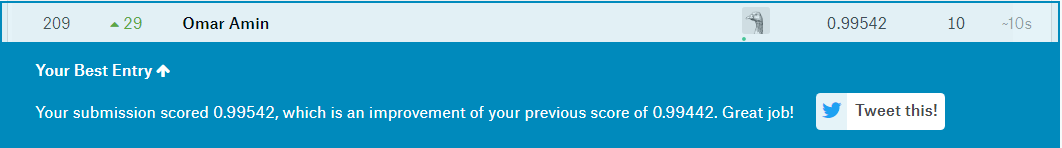

## Ensemble Predictions

In [38]:
drop_outs = [0.45,0.44,0.45]
results = []
for idx,drop_out in enumerate(drop_outs):
    #print(path + '_'+ str(drop_out)+'_ensemble_' + str(idx)+'.h')
    model = load_model(path + '_'+ str(drop_out)+'_ensemble_' + str(idx)+'.h')
    predictions = model.predict(test_x)
    results.append(predictions)
results = np.array(results)
results = np.mean(results,axis = 0)
result = np.argmax(results,axis = 1)


In [39]:
result = result.reshape((test_x.shape[0],1))
ids = (np.arange(test_x.shape[0])+1).reshape((test_x.shape[0],1))
result = np.hstack((ids,result))
m = to_kaggle_csv(result,['ImageId','Label'], '4-sub_adam_cnn_2c_1p_2c_1p_valid9958_ensemble.csv')

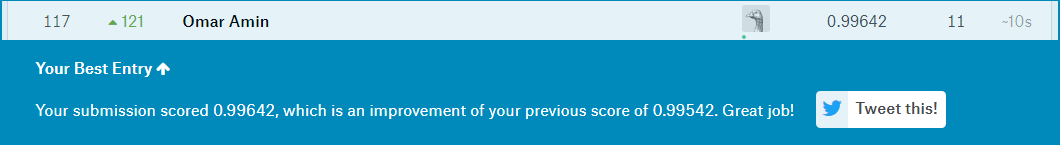

## TTA (Test Time Augmentation)

In [56]:
def TTA_predict(model, test_data, nb_classes = 10):
    datagen = ImageDataGenerator( rotation_range=15, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.1,
        zoom_range=0.2, fill_mode='nearest')
    predictions = np.zeros((test_data.shape[0],nb_classes))
    for idx,img in enumerate(test_data):
        if idx %1000 == 0:
            print(idx)
        TTA_batch = np.zeros((10,)+test_data.shape[1:])
        x2 = img.reshape((1,)+img.shape)
        TTA_batch[0,:] = img
        i = 0
        for batch in datagen.flow(x2,batch_size=1):
            i+=1
            if i>9:
                break # otherwise the generator would loop indefinitely
            #print(i)
            TTA_batch[i,:] = batch.reshape(img.shape)
        
        TTA_predictions = model.predict(TTA_batch)
        TTA_predictions = TTA_predictions.mean(axis = 0)
        predictions[idx,:] = TTA_predictions
    return predictions

In [83]:
drop_outs = [0.45,0.44,0.45]
results = []
for idx,drop_out in enumerate(drop_outs):
    #print(path + '_'+ str(drop_out)+'_ensemble_' + str(idx)+'.h')
    model = load_model(path + '_'+ str(drop_out)+'_ensemble_' + str(idx)+'.h')
    predictions = TTA_predict(model,test_x)
    results.append(predictions)
results = np.array(results)
results = np.mean(results,axis = 0)
result = np.argmax(results,axis = 1)
result = result.reshape((test_x.shape[0],1))
ids = (np.arange(test_x.shape[0])+1).reshape((test_x.shape[0],1))
result = np.hstack((ids,result))
m = to_kaggle_csv(result,['ImageId','Label'], '4-sub_adam_cnn_2c_1p_2c_1p_valid9958_ensemble_with_TTA.csv')

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000


In [82]:
g_truth = np.argmax(valid_y,axis = 1)
print(np.sum(result == g_truth)*1.0/result.shape[0])
print(result.shape,g_truth.shape)

0.995714285714
(8400,) (8400,)


(9, 28, 28, 1)


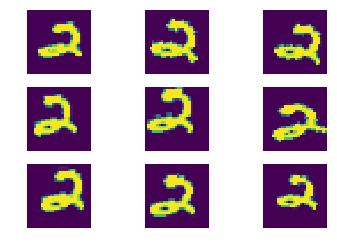

NameError: name 'model' is not defined

In [8]:
### debugging section
x = test_x[0,:]
datagen = ImageDataGenerator( rotation_range=15, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.1,
        zoom_range=0.2, fill_mode='nearest')
x2 = x.reshape((1,)+x.shape)

TTA_batch = np.zeros((9,)+test_x.shape[1:])
i = -1
for batch in datagen.flow(x2,batch_size=1):
    i+=1
    if i>8:
        break # otherwise the generator would loop indefinitely
    TTA_batch[i,:] = batch.reshape(x.shape)
    #plt.imshow(TTA_batch[i,:].reshape(x.shape)[:,:,0])
    #plt.show()

print(TTA_batch.shape)
i = 0
for im in TTA_batch:
    i+=1
    temp = im.reshape(x.shape)
    plt.subplot(3,3,i)
    #print(temp.shape)
    if i == 0:
        plt.imshow(x[:,:,0])
    else:
        plt.imshow(temp[:,:,0])
    plt.axis('off')

plt.show()

preds = model.predict(TTA_batch)
print(preds.shape)
preds = preds.mean(axis = 0)
print(preds.shape)
predss = np.zeros((2,10))
predss[0,:] = preds
predss[1,:] = preds
print(predss)